In [296]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib

model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
model_rfr_hpo = joblib.load('savemodel_rfr_ftr_hpo.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')

model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [297]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [298]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [299]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [300]:
x_pre = imputer.transform(dfpre)

In [301]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [302]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [303]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001


In [304]:
dfpre["True North Wind Direction"] =  180 +  np.rad2deg(np.arctan((dfpre["eastwind"])/(dfpre["northwind"])))

# dfpre["True North Wind Direction"] = np.where(dfpre["True North Wind Direction"] > 0, 180 + dfpre["True North Wind Direction"] , 180 - dfpre["True North Wind Direction"])

# if dfpre["True North Wind Direction"]<0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]
# elif dfpre["True North Wind Direction"]>0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]

In [305]:
dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

In [306]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [307]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,198.591820,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,195.541109,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,190.250337,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,183.275496,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [308]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [309]:
# Exclude data for the month of June to check the model's forecasting performance 

dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

# Extract information of a journey from a single day

koege_dep = df[df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S') == '2021-05-31 23:00:00']
koege_arr = dfdate6[dfdate6['Time'].dt.strftime('%Y-%m-%d') == '2021-06-01']

# Drop the departure time for next trip

koege_arr2 = koege_arr.drop(koege_arr.index[14])

# To gain information for a single trip from Koege to Ronne

ronne_arr = koege_arr.drop(koege_arr.index[4:15])

dfday6 = pd.concat([koege_dep,koege_arr2])
dfone6 = pd.concat([koege_dep,ronne_arr])

# # For Qgis Single Journey
# dfday6.to_csv("AIS_01_06_21_koegeronne.csv")

Special Section

In [310]:
# # Check model performance for one trip
# # PLEASE COMMMENT WHEN DONE !!!

# dfdate6 = dfone6

Measure performance in one month

In [311]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,100.989288,164.871808,15.554049,66.843493,57.268527,0.144914,10.248966,201.771601,85.654121
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,108.737155,153.650411,11.071672,60.455881,51.313932,0.246220,11.364678,205.671971,70.585227
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,114.910729,153.031589,16.281358,57.086511,46.894106,0.284315,12.666946,212.436488,70.557348
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,123.568984,153.643227,69.175152,55.507286,56.527939,0.300428,13.386999,230.510505,80.584748
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,26.476633,41.766758,158.632374,159.050718,167.192888,0.262897,12.053293,254.157471,89.447596


In [312]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [313]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

dfdate6 = dfdate6[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


# dfdate6 = dfdate6[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [314]:
stats2 = dfdate6['curspeed'].value_counts()

In [315]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)


In [316]:
imputer.fit(dfdate6)

KNNImputer(n_neighbors=50)

In [317]:
xdate = imputer.transform(dfdate6)

In [318]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [319]:
x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date = dfdate6tr.sog

In [320]:
def predict_y(x_test,model_type):
    y_predicted = model_type.predict(x_test)
    return y_predicted

def display_scores(x_test,y_test,model_type,y_predicted):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error
    print("R^2 score (Indicate model fit. Best Score = 1):", model_type.score(x_test,y_test))
    print("Explained Variance EV (Indicate amount of variance in model. Best Score = 1):", explained_variance_score(y_test,y_predicted))
    print("Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0):", mean_absolute_error(y_test,y_predicted))
    print("Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0):", mean_squared_error(y_test,y_predicted))
    print("Median Absolute Error MAD (Check robustness against outlier. Best Score = 1):", median_absolute_error(y_test,y_predicted))

y_pred_rfr_ftr = predict_y(x_date,model_rfr_ftr)
display_scores(x_date,y_date,model_rfr_ftr,y_pred_rfr_ftr)

R^2 score (Indicate model fit. Best Score = 1): 0.8661050856280904
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8850235304894934
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8120179128967392
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.2579811826079608
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.6359169406449978


In [321]:
# Prediction using FTR + HPO

y_pred_rfr_hpo = predict_y(x_date,model_rfr_hpo)
display_scores(x_date,y_date,model_rfr_hpo,y_pred_rfr_hpo)


R^2 score (Indicate model fit. Best Score = 1): 0.8669978195823334
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8853816478907424
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8130371046454223
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.2495936906648886
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.6429208845000058


In [322]:
# Comparing performance with DTR model (not optimzed)

y_pred_dtr_ftr = predict_y(x_date,model_dtr_ftr)
display_scores(x_date,y_date,model_dtr_ftr,y_pred_dtr_ftr)

R^2 score (Indicate model fit. Best Score = 1): 0.814343145225526
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8345189699106536
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.977445138978261
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.7442994816049961
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.7392370600000007


In [323]:
# Comparing performacw with MLR as baseline (not optimzed)

y_pred_mlr_ftr = predict_y(x_date,model_mlr_ftr)
display_scores(x_date,y_date,model_mlr_ftr,y_pred_mlr_ftr)

R^2 score (Indicate model fit. Best Score = 1): 0.5739398047508771
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.596392988232809
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 1.4264762308245376
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 4.002957922605872
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 1.2897330038744261


In [324]:
ydate_pred = y_pred_rfr_hpo
dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
dfprog_sog["sog_pred"] = ydate_pred
dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
dfprog_sog["nwinddir"] = dfdate6tr["truenorthwinddir"]

print(dfprog_sog)

        sog_act   sog_pred      gamma    nwinddir
119   18.998906  18.515334  85.654121  201.771601
120   19.334278  18.672305  70.585227  205.671971
121   18.911047  18.666529  70.557348  212.436488
122   13.854933  13.988040  80.584748  230.510505
126    9.305198  11.238711  89.447596  254.157471
...         ...        ...        ...         ...
7413  19.072622  18.320524 -75.033834  110.959927
7414  17.696584  17.484775  86.330174  126.837339
7415  15.963630  16.354070  83.486098  119.018621
7418   8.988086   8.625746  89.745593  140.723377
7419  17.672769  17.341614  15.792214  143.902554

[322 rows x 4 columns]


In [325]:
dfprog = pd.concat([x_date,dfprog_sog],axis=1)
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act,sog_pred,gamma,nwinddir
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,100.989288,164.871808,57.268527,18.998906,18.515334,85.654121,201.771601
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,108.737155,153.650411,51.313932,19.334278,18.672305,70.585227,205.671971
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,114.910729,153.031589,46.894106,18.911047,18.666529,70.557348,212.436488
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,123.568984,153.643227,56.527939,13.854933,13.988040,80.584748,230.510505
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,26.476633,41.766758,167.192888,9.305198,11.238711,89.447596,254.157471
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,49.650197,36.203894,119.939682,20.935741,17.376205,85.735437,252.289134
128,275.499359,5.927387,287.021892,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,11.124505,16.745666,176.253205,12.419853,12.643351,87.870444,240.000273
130,276.370789,5.959699,286.794441,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,121.750507,148.640604,54.778275,20.447721,16.028726,-84.704755,248.405148
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,156.811217,154.901600,41.385363,18.702889,16.690912,82.800757,264.710374
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,1.584058,10.961510,159.775304,16.155258,16.301148,-78.378834,269.075598


In [326]:
# Conversion of predicted SOG to m/s

dfprog["vgms"] = dfprog["sog_pred"]/1.9438

# Conversion of actual SOG to m/s

dfprog["vgms_act"] = dfprog["sog_act"]/1.9438

In [327]:
# Conversion of the angles to radian

rad_gamma = np.deg2rad(dfprog["gamma"])
rad_cog = np.deg2rad(dfprog["cog"])

In [328]:
# Calculation of the predicted x-component of SOG

dfprog["vgx"] = dfprog["vgms"] * np.sin(rad_cog)
dfprog["vcx"] = dfprog["curspeed"] * np.sin(rad_gamma)
dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

# Calculation of the actual x-component of SOG

dfprog["vgx_act"] = dfprog["vgms_act"] * np.sin(rad_cog)
dfprog["stw_x_act"] = (dfprog["vgx_act"] - dfprog["vcx"])


In [329]:
# Calculation of the predicted y-component of SOG 

dfprog["vgy"] = dfprog["vgms"] * np.cos(rad_cog)
dfprog["vcy"] = dfprog["curspeed"] * np.cos(rad_gamma)
dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

# Calculation of the actual y-component of SOG

dfprog["vgy_act"] = dfprog["vgms_act"] * np.cos(rad_cog)
dfprog["stw_y_act"] = (dfprog["vgy_act"] - dfprog["vcy"])


In [330]:
# For the actual data
dfprog["vwms_a"] = np.sqrt(dfprog["stw_x_act"]**2 + dfprog["stw_y_act"]**2)
dfprog["stw_act"] = dfprog["vwms_a"]*1.9438

# For the prediction

dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
dfprog["stw_pred"] = dfprog["vwms_p"]*1.9438



In [331]:
dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
                      'vgy','vcy','stw_y',
                      'vgms_act','vgx_act','stw_x_act',
                      'vgy_act','stw_y_act',
                      'vwms_p','vwms_a'],axis=1)
#df_ship.head(n=5)
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,100.989288,164.871808,57.268527,18.998906,18.515334,85.654121,201.771601,18.729972,18.246406
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,108.737155,153.650411,51.313932,19.334278,18.672305,70.585227,205.671971,18.913459,18.251534
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,114.910729,153.031589,46.894106,18.911047,18.666529,70.557348,212.436488,18.429833,18.185342
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,123.568984,153.643227,56.527939,13.854933,13.988040,80.584748,230.510505,13.276732,13.409837
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,26.476633,41.766758,167.192888,9.305198,11.238711,89.447596,254.157471,9.009772,10.941635
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,49.650197,36.203894,119.939682,20.935741,17.376205,85.735437,252.289134,21.221281,17.661951
128,275.499359,5.927387,287.021892,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,11.124505,16.745666,176.253205,12.419853,12.643351,87.870444,240.000273,12.753846,12.977213
130,276.370789,5.959699,286.794441,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,121.750507,148.640604,54.778275,20.447721,16.028726,-84.704755,248.405148,20.747280,16.328549
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,156.811217,154.901600,41.385363,18.702889,16.690912,82.800757,264.710374,18.470818,16.458884
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,1.584058,10.961510,159.775304,16.155258,16.301148,-78.378834,269.075598,15.886581,16.032471


In [332]:
dfprog.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,287.133146,3.393579,287.278174,0.655332,5.282713,197.436423,189.432992,5.832751,0.092478,86.173628,86.811052,96.133203,17.449699,17.034102,-11.849461,179.967365,17.440998,17.025411
std,6.306975,0.964939,4.798404,0.542441,0.162420,86.327689,88.499255,3.020207,0.068917,62.588681,59.359251,61.547388,3.069944,2.742540,55.353826,63.036318,3.059230,2.723084
min,269.606903,1.915993,275.485352,0.073242,4.754639,82.664990,79.551648,0.441768,0.002006,0.565115,1.295289,0.200645,5.224523,5.990357,-89.500098,90.107133,5.211211,6.024991
25%,285.292786,2.692099,286.837568,0.272528,5.199718,103.569971,101.685445,3.442231,0.043318,24.875738,28.600108,35.663590,16.568861,16.651843,-60.671287,119.047681,16.581974,16.576540
50%,289.505615,3.162097,289.004578,0.465021,5.290842,193.360899,125.125521,5.528616,0.073482,82.212973,79.271353,103.381967,18.413643,18.080753,-26.065061,170.499216,18.399973,18.001762
75%,291.391602,3.734216,290.458008,0.769191,5.381292,283.259801,279.238872,7.569939,0.123647,149.107733,146.039105,158.470366,19.421633,18.613075,35.032562,244.414903,19.417551,18.562024
max,294.685303,6.291378,292.665649,2.565230,5.657671,319.851509,304.969531,13.386999,0.417155,179.309007,179.405213,179.699225,21.031230,19.714688,89.975398,269.737370,21.221281,19.800841


In [333]:
# FOC in T/d
dfprog["foc_act_d"] = ((dfprog["stw_act"]/17.7)**3) * 21.14112
dfprog["foc_pred_d"] = ((dfprog["stw_pred"]/17.7)**3) * 21.14112

# FOC in T/h
dfprog["foc_act_h"] = ((dfprog["stw_act"]/17.7)**3) * 0.8808
dfprog["foc_pred_h"] = ((dfprog["stw_pred"]/17.7)**3) * 0.8808

In [334]:
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,...,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred,foc_act_d,foc_pred_d,foc_act_h,foc_pred_h
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,100.989288,...,18.998906,18.515334,85.654121,201.771601,18.729972,18.246406,25.050684,23.160087,1.043684,0.964916
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,108.737155,...,19.334278,18.672305,70.585227,205.671971,18.913459,18.251534,25.794140,23.179620,1.074658,0.965730
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,114.910729,...,18.911047,18.666529,70.557348,212.436488,18.429833,18.185342,23.865601,22.928340,0.994310,0.955261
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,123.568984,...,13.854933,13.988040,80.584748,230.510505,13.276732,13.409837,8.922402,9.193453,0.371733,0.383026
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,26.476633,...,9.305198,11.238711,89.447596,254.157471,9.009772,10.941635,2.788365,4.994073,0.116171,0.208067
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,49.650197,...,20.935741,17.376205,85.735437,252.289134,21.221281,17.661951,36.435353,21.005076,1.518002,0.875132
128,275.499359,5.927387,287.021892,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,11.124505,...,12.419853,12.643351,87.870444,240.000273,12.753846,12.977213,7.909183,8.332062,0.329519,0.347138
130,276.370789,5.959699,286.794441,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,121.750507,...,20.447721,16.028726,-84.704755,248.405148,20.747280,16.328549,34.048008,16.597818,1.418538,0.691513
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,156.811217,...,18.702889,16.690912,82.800757,264.710374,18.470818,16.458884,24.025177,16.998451,1.000958,0.708204
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,1.584058,...,16.155258,16.301148,-78.378834,269.075598,15.886581,16.032471,15.286199,15.711207,0.636867,0.654574


In [335]:
# df_foc=dfprog.drop(['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod',
#                     'surftemp','windwaveswellheight','swellheight','windwaveheight','swellheight',
#                     'windwaveheight','draught','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir',
#                     'truewavedir','gamma','nwinddir'],axis=1)

df_foc=dfprog.drop(['oceantemperature','waveperiod',
                    'surftemp','windwaveswellheight',
                    'draught','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir',
                    'truewavedir','gamma','nwinddir'],axis=1)

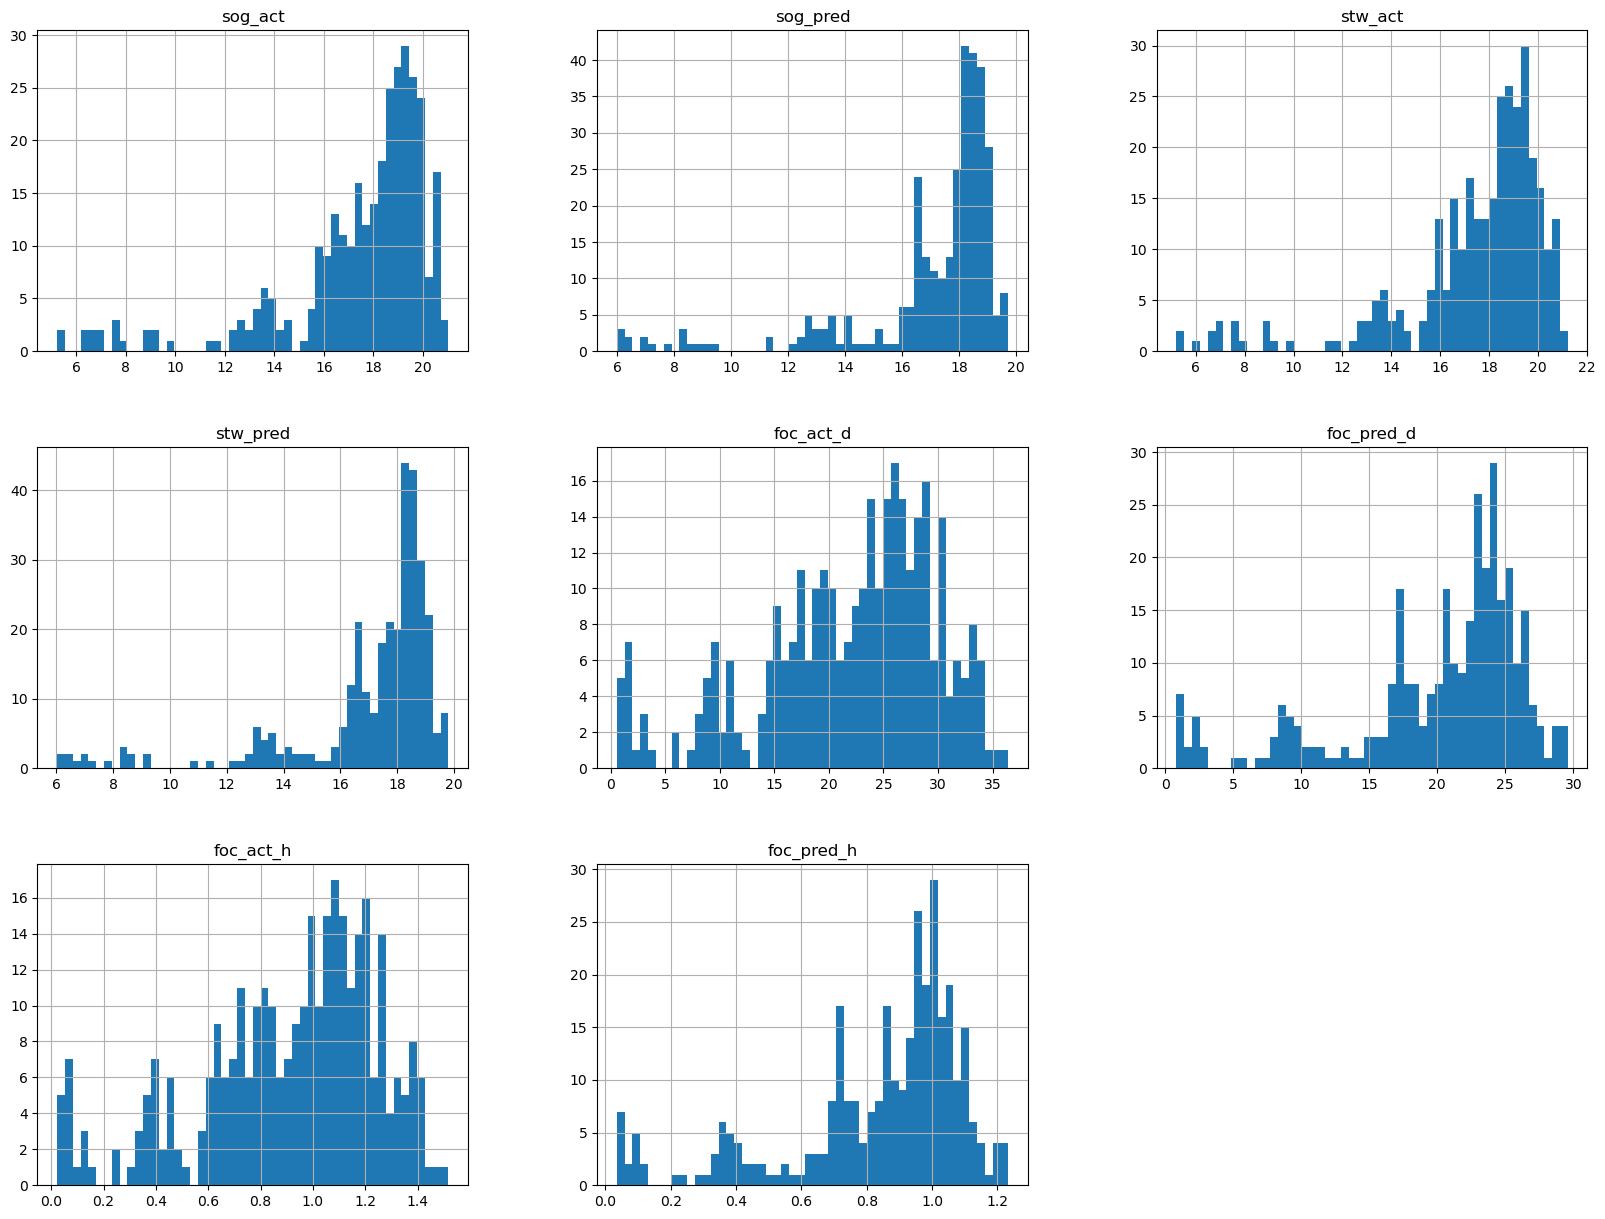

In [336]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_foc.hist(bins=50,figsize=(20,15))
plt.show()

In [337]:
foc_month = dfprog['foc_pred_d'].mean()
foc_month_a = dfprog['foc_act_d'].mean()
print(f"Mean of predicted FOC in a month is {foc_month} T/d")
print(f"Mean of actual FOC in a month is {foc_month_a} T/d")

Mean of predicted FOC in a month is 20.077568341827558 T/d
Mean of actual FOC in a month is 21.87772146283159 T/d


In [338]:
foc_trip = dfprog['foc_pred_h'].mean() * 4
foc_trip_a = dfprog['foc_act_h'].mean() * 4
foc_trip_err = foc_trip_a - foc_trip
print(f"Mean of predicted FOC in a 4h trip is {foc_trip} T")
print(f"Mean of actual FOC in a trip in a 4h trip is {foc_trip_a} T")
print(f"Error is {foc_trip_err} T")

Mean of predicted FOC in this 4h trip is 3.345957488625335 T
Mean of actual FOC in a trip in this 4h trip is 3.6459557609931856 T
Error is 0.2999982723678505 T
